In [2]:
path = "/home/mila/d/dereck.piche/scratch/llm_negotiation/2025-06-07___16-29-53_negotiation_game_normalized/seed_344"

In [3]:
import matplotlib.pyplot as plt
import os
import json
import numpy as np


def get_from_nested_dict(dictio: dict, path: list[str]):
    for sp in path[:-1]:
        dictio = dictio[sp]
    return dictio.get(path[-1])

def set_at_path(dictio: dict, path: list[str], value):
    for sp in path[:-1]:
        if sp not in dictio:
            dictio[sp] = {}
        dictio = dictio[sp]
    dictio[path[-1]] = value


def produce_tabular_render(inpath: str, outpath: str = None):
    """
    TODO: docstring
    """
    with open(inpath, "r") as f:
        data = json.load(f)
    rollout_paths = data.keys()
    for rollout_path in rollout_paths:
        if outpath is None:
            m_path = rollout_path.replace("/", "|")
            m_path = m_path.replace(".json", "")
            m_path = (
                os.path.split(inpath)[0]
                + "/contextualized_tabular_renders/"
                + m_path
                + "_tabular_render.csv"
            )
        # import pdb; pdb.set_trace()
        os.makedirs(os.path.split(m_path)[0], exist_ok=True)
        metrics = data[rollout_path]
        d = {k: [] for k in metrics[0].keys()}
        for m in metrics:
            for k, v in m.items():
                d[k].append(v)
        d = pd.DataFrame(d)
        d.to_csv(m_path)

def get_metric_paths(data: list[dict]):
    d = data[0]
    paths = []
    def traverse_dict(d, current_path=[]):
        for key, value in d.items():
            new_path = current_path + [key]
            if isinstance(value, dict):
                traverse_dict(value, new_path)
            else:
                paths.append(new_path)
    traverse_dict(d)
    return paths

def print_metric_paths(data: list[dict]):
    paths = get_metric_paths(data)
    for p in paths: print(p)


def get_metric_iteration_list(data: list[dict], metric_path: list[str]):
    import copy
    sgl = []
    for d in data:
        sgl.append(get_from_nested_dict(d, metric_path))


def to_1d_numeric(x):
    """Return a 1-D float array (or None if not numeric)."""
    if x is None:
        return None
    # Scalars
    if isinstance(x, (int, float, np.number)):
        return np.array([float(x)])

    # Anything list‑like → recurse & flatten
    try:
        flat = np.array(list(np.ravel(x)), dtype=float)
        return flat
    except Exception:
        return None    # skip non‑numeric or badly structured payloads


def get_single_metric_vector(data, metric_path, iterations=None):
    vecs = []
    for d in data:
        ar = get_from_nested_dict(d, metric_path)
        arr = to_1d_numeric(ar)
        if arr is not None:
            vecs.append(arr)

    return np.concatenate(vecs) if vecs else np.empty(0, dtype=float)



def get_iterations_data(iterations_path: str):
    iterations_data = []
    more_iterations = True
    paths = os.listdir(iterations_path)
    n = 0
    iteration_path = os.path.join(iterations_path, f"iteration_{n:03d}")
    while more_iterations:
        if os.path.isdir(iteration_path):
            for root, dirs, files in os.walk(iteration_path):
                for file in files:
                    if file.startswith("basic_training_metrics"):
                        file_path = os.path.join(root, file)
                        with open(file_path, "r") as f:
                            iterations_data.append(json.load(f))
        else:
            more_iterations = False
        n += 1
        iteration_path = os.path.join(iterations_path, f"iteration_{n:03d}")
    return iterations_data



In [4]:
data = get_iterations_data(path)

# Get Stats

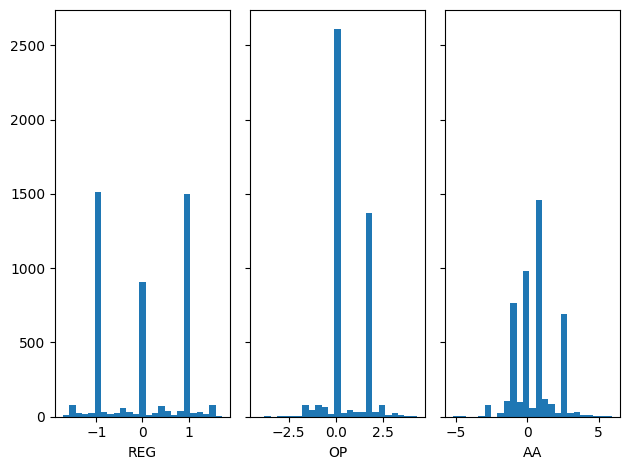

In [5]:
reg_scores = get_single_metric_vector(data, ['a1_after_normalizing'], range(len(data)))
op_terms = get_single_metric_vector(data, ['ad_align_opp_shaping_terms'], range(len(data)))
aa_scores = get_single_metric_vector(data, ['final_advantage_alignment_scores'], range(len(data)))
n_bins = 25


fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(reg_scores, bins=n_bins)
axs[0].set_xlabel('REG')
axs[1].hist(op_terms, bins=n_bins)
axs[1].set_xlabel('OP')
axs[2].hist(aa_scores, bins=n_bins)
axs[2].set_xlabel('AA')
plt.show()

In [9]:
print("Reg. Mean: ", np.mean(reg_scores))
print("Reg. STD: ", np.std(reg_scores))
print("OP Mean: ", np.mean(op_terms))
print("OP STD: ", np.std(op_terms))
print("AA Mean: ", np.mean(aa_scores))
print("AA STD: ", np.std(aa_scores))
print("AA min: ", np.min(aa_scores))
print("AA max: ", np.max(aa_scores))

Reg. Mean:  -4.095874873834128e-18
Reg. STD:  0.8980095591620315
OP Mean:  0.5310611524103052
OP STD:  0.9698671057807039
AA Mean:  0.5310611524103053
AA STD:  1.343826898496074
AA min:  -5.202641879505279
AA max:  5.93933628710069


In [7]:
N = reg_scores.size
print("Corr. Coeff Reg & AA", np.corrcoef(reg_scores[:N], aa_scores[:N])[0,1])
print("Corr. Coeff OP & AA", np.corrcoef(op_terms[:N], aa_scores[:N])[0,1])

Corr. Coeff Reg & AA 0.6926135588170511
Corr. Coeff OP & AA 0.7442806314088405
